# Imports

In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures

In [2]:
%load_ext lab_black

# Data

In [3]:
# read in all the words
with open("../data/names.txt", "r") as f:
    words = f.read().splitlines()
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [17]:
VOCAB_SZ = len(stoi)
GEN_SEED = 2147483647
RANDOM_SEED = 42
BLOCK_SZ = 8  # context length: how many characters do we take to predict the next one
HIDDEN_DIM = 128
EMB_DIM = 24
BATCH_SZ = 32

In [6]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * BLOCK_SZ
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [7]:
# Split data: 80% training, 10% validation, 10% test
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

Xtr.shape, Xdev.shape, Xte.shape

(torch.Size([182625, 8]), torch.Size([22655, 8]), torch.Size([22866, 8]))

In [8]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print("".join(itos[ix.item()] for ix in x), "-->", itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


# Wavenet

In [20]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        # Kaiming initialization
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [10]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [11]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            dim = 0 if x.ndim == 2 else (0, 1)
            xmean = x.mean(dim, keepdim=True)  # batch mean
            xvar = x.var(dim, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [12]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

In [13]:
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

In [14]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [15]:
torch.manual_seed(RANDOM_SEED)

In [28]:
model = Sequential(
    [
        Embedding(VOCAB_SZ, EMB_DIM),
        FlattenConsecutive(2),
        Linear(EMB_DIM * 2, HIDDEN_DIM, bias=False),
        BatchNorm1d(HIDDEN_DIM),
        Tanh(),
        FlattenConsecutive(2),
        Linear(HIDDEN_DIM * 2, HIDDEN_DIM, bias=False),
        BatchNorm1d(HIDDEN_DIM),
        Tanh(),
        FlattenConsecutive(2),
        Linear(HIDDEN_DIM * 2, HIDDEN_DIM, bias=False),
        BatchNorm1d(HIDDEN_DIM),
        Tanh(),
        Linear(HIDDEN_DIM, VOCAB_SZ),
    ]
)

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1  # last layer make less confident

parameters = model.parameters()
for p in parameters:
    p.requires_grad = True

In [42]:
for layer in model.layers:
    print(f"{layer.__class__.__name__} : {layer.out.shape}")

Embedding : torch.Size([1, 8, 24])
FlattenConsecutive : torch.Size([1, 4, 48])
Linear : torch.Size([1, 4, 128])
BatchNorm1d : torch.Size([1, 4, 128])
Tanh : torch.Size([1, 4, 128])
FlattenConsecutive : torch.Size([1, 2, 256])
Linear : torch.Size([1, 2, 128])
BatchNorm1d : torch.Size([1, 2, 128])
Tanh : torch.Size([1, 2, 128])
FlattenConsecutive : torch.Size([1, 256])
Linear : torch.Size([1, 128])
BatchNorm1d : torch.Size([1, 128])
Tanh : torch.Size([1, 128])
Linear : torch.Size([1, 27])


In [29]:
print(sum(p.nelement() for p in parameters))  # number of parameters in total

76579


In [30]:
# same optimization as last time
max_steps = 200_000
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SZ,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.2972
  10000/ 200000: 1.8948
  20000/ 200000: 1.9175
  30000/ 200000: 1.7726
  40000/ 200000: 2.0583
  50000/ 200000: 2.3551
  60000/ 200000: 1.9154
  70000/ 200000: 2.1600
  80000/ 200000: 1.9745
  90000/ 200000: 2.2342
 100000/ 200000: 2.1690
 110000/ 200000: 2.1292
 120000/ 200000: 1.9780
 130000/ 200000: 1.4243
 140000/ 200000: 1.6436
 150000/ 200000: 2.0119
 160000/ 200000: 1.9603
 170000/ 200000: 1.6494
 180000/ 200000: 1.8338
 190000/ 200000: 1.7003


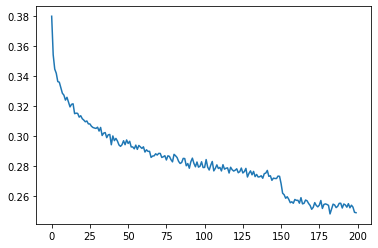

In [32]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [33]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [34]:
# evaluate the loss
@torch.no_grad()  # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [35]:
split_loss("train")
split_loss("val")

train 1.7657175064086914
val 1.9954216480255127


In [37]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * BLOCK_SZ  # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))  # decode and print the generated word

wynslon.
damontaila.
alleigh.
breckay.
laylyn.
zayda.
oluwatome.
kashir.
yege.
masai.
kadey.
mire.
kyalu.
knoe.
brennsole.
ninai.
hase.
deloni.
jesidy.
marionna.
